## 此專案用於開發 RUL 預測程式的最終版本, 此處先以單點分析再推廣至多工況 ##
## 請勿改動: 此版本是驗證過 EVCC 有較好診斷功能的版本，如後續分析效果不好可再退回 ##
### 此程式用於測試 EMF vs I 兩種不同物理量輸入模型之差異 (比較好解釋) ###
### 模型採用 雙LSTM層轉譯 + Attesntion + 未來資訊輸入 來更好預測序列 ###
### 2025 08011 ###




### 導入模型設定與套件 ###

In [93]:
# import used functioons 
#  import tools 
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Conv1D, Dense, concatenate, RepeatVector, MaxPooling1D, Activation ,UpSampling1D, Conv1DTranspose
from tensorflow.keras.layers import Add, Concatenate,LSTM, TimeDistributed, MultiHeadAttention, LayerNormalization


from tensorflow.keras.utils import plot_model

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU devices found:")
    for gpu in gpus:
        print(gpu)
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

import numpy as np 
import pandas as pd
from openpyxl import Workbook
import matplotlib.pyplot as plt
import os
import sys
import csv
import time
from IPython import embed

from rul_features.rul_data_read import read_rul_data

from test_algs.CCAE_ntu_rul import get_initial_files_datalist, CCAE_train
from test_algs.CCAE_ntu_rul import CCAE_model_application, CCAE_model_build_train

import random
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(42)



GPU devices found:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


### 確立訓練工況檔案來源 ###
使用 CCAE 範本作為正常工況

In [94]:
from datetime import datetime
import json
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, LSTM, Dense, Average, Add, Multiply, Lambda, GlobalAveragePooling1D
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model


# Initial model parameters
sequence_length=1024
layer_number=1
future_length=512

model_folder_path = r'NTU_rul_models\CCAE_models'
model_name = f'0811_multiscale_CCAE_Base{sequence_length}Future{future_length}'
model_path = os.path.join(model_folder_path, model_name)
os.makedirs(model_path, exist_ok=True)

from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, TimeDistributed, AdditiveAttention

def build_cnn_multi_branch_ae(
    input_dim_list,
    sequence_length,
    condition_dim,
    model_folder_path=None,
    model_name=None,
    iscondition=True,
    kernel_sizes=(3, 5, 7),
    base_filters=32,
    blocks=3,
    decay=0.5,
    filters_per_block=None
):
    """
    CNN-based multi-branch Autoencoder (可指定層數):
    - (可選) 將條件向量 repeat 到序列長度後與輸入串接
    - Encoder: 三/多個平行分支 (依 kernel_sizes)；每分支做 [Conv1D+Pool]*blocks
    - Bottleneck: 1 層 Conv1D
    - Decoder: 鏡像 [UpSampling+Conv1D]*blocks
    - Merge: 各分支 decoder 輸出 concat，再 Conv1D 融合
    - Output: 逐時間步 Dense 到各輸出通道
    參數:
      - blocks: 每個分支的編碼/解碼層數
      - base_filters + decay: 例如 32, 0.5 -> [32, 16, 8, ...]
      - filters_per_block: 明確指定每層 filters (長度需 >= blocks)；若提供則覆蓋 base_filters/decay
    備註：MaxPool/UpSampling 使用倍率 2；sequence_length 不需為 2^blocks 的倍數 (same padding)。
    """
    from tensorflow.keras.layers import (
        Input, Concatenate, Conv1D, MaxPooling1D, Dense,
        UpSampling1D, RepeatVector
    )
    from tensorflow.keras.models import Model

    assert blocks >= 1, "blocks 必須 >= 1"
    if filters_per_block is not None:
        assert len(filters_per_block) >= blocks, "filters_per_block 長度需 >= blocks"
        f_list = [int(max(1, f)) for f in filters_per_block[:blocks]]
    else:
        # 依 base_filters 與 decay 自動產生每層的 filters
        f_list = [int(max(1, round(base_filters * (decay ** i)))) for i in range(blocks)]

    # === Series Inputs ===
    inputs = []
    for idx, input_dim in enumerate(input_dim_list):
        input_layer = Input(shape=(sequence_length, input_dim), name=f'series_{idx}')
        inputs.append(input_layer)
    # 當只有一個輸入時，直接使用；否則再 concat
    if len(inputs) == 1:
        series_input = inputs[0]
    else:
        series_input = Concatenate(axis=-1, name='series_input_concat')(inputs)

    # === Condition inputs ===
    condition_input_1 = Input(shape=(condition_dim,), name='condition_1')
    condition_input_2 = Input(shape=(condition_dim,), name='condition_2')
    merged_condition = Concatenate(name="merged_condition")([condition_input_1, condition_input_2])

    # === (Optional) repeat condition and concat ===
    x_in = series_input
    if iscondition:
        repeated_condition = RepeatVector(sequence_length, name="cond_repeat")(merged_condition)
        x_in = Concatenate(axis=-1, name='series_with_condition')([x_in, repeated_condition])

    # === Helper: one CNN AE branch (encoder + decoder) ===
    def cnn_branch(x, k, name_prefix):
        z = x
        # Encoder: [Conv + Pool]*blocks
        for b in range(blocks):
            z = Conv1D(f_list[b], k, padding='same', activation='relu',
                       name=f'{name_prefix}_enc_c{b+1}')(z)
            z = MaxPooling1D(pool_size=2, name=f'{name_prefix}_enc_p{b+1}')(z)

        # Bottleneck
        z = Conv1D(f_list[-1], k, padding='same', activation='relu',
                   name=f'{name_prefix}_bottleneck')(z)

        # Decoder: 鏡像 [Up + Conv]*blocks
        for b in reversed(range(blocks)):
            z = UpSampling1D(size=2, name=f'{name_prefix}_dec_u{blocks-b}')(z)
            z = Conv1D(f_list[b], k, padding='same', activation='relu',
                       name=f'{name_prefix}_dec_c{blocks-b}')(z)

        return z  # 與輸入同長度的特徵圖

    # === Build branches ===
    branch_outputs = []
    for k in kernel_sizes:
        branch_outputs.append(cnn_branch(x_in, k, name_prefix=f'branch_k{k}'))

    # === Merge branches and fuse ===
    merged = Concatenate(axis=-1, name='decoder_branches_concat')(branch_outputs)
    # 用 1x1 做通道壓縮，再 3x1 融合
    fused = Conv1D(max(f_list[0], base_filters), 1, padding='same', activation='relu', name='fusion_conv1x1')(merged)
    fused = Conv1D(max(f_list[0], base_filters), 3, padding='same', activation='relu', name='fusion_conv3')(fused)

    # === Output per channel (逐時間步 Dense 到各輸出維度)
    output_list = [
        Dense(dim, activation='linear', name=f'output_{idx}')(fused)
        for idx, dim in enumerate(input_dim_list)
    ]

    model = Model(
        inputs=inputs + [condition_input_1, condition_input_2],
        outputs=output_list,
        name=f'CNN_MultiBranch_AE_{series_input.shape[-1]}in_{len(output_list)}out_b{blocks}'
    )
    return model

def build_ccae_conditioned_model(
    input_dim_list,
    sequence_length,
    condition_dim,
    model_folder_path=None,
    model_name=None,
    iscondition=True
):
    """
    CCAE (Convolutional Conditioned AutoEncoder)
    - (可選) 兩個 condition 向量先 concat，再 repeat 到時間軸後與 Encoder 輸入串接
    - Decoder 端同樣將 condition repeat 到編碼後的時間長度並與 decoder 輸入串接
    """

    from tensorflow.keras.layers import (
        Input, Concatenate, RepeatVector, Conv1D, MaxPooling1D,
        Activation, Dense, UpSampling1D
    )
    # 有些 Keras 版本沒有 Conv1DTranspose，可用 UpSampling1D+Conv1D 近似；若你環境已有可直接 import
    try:
        from tensorflow.keras.layers import Conv1DTranspose
        HAS_CONV1DT = True
    except Exception:
        HAS_CONV1DT = False

    from tensorflow.keras.models import Model

    # === Series inputs ===
    inputs = []
    for idx, input_dim in enumerate(input_dim_list):
        input_layer = Input(shape=(sequence_length, input_dim), name=f'series_{idx}')
        inputs.append(input_layer)

    # === Condition inputs (移植自前一支程式碼) ===
    condition_input_1 = Input(shape=(condition_dim,), name='condition_1')
    condition_input_2 = Input(shape=(condition_dim,), name='condition_2')
    merged_condition = Concatenate(name="merged_condition")([condition_input_1, condition_input_2])

    # === Encoder ===
    # (可選) 將 merged_condition repeat 到序列長度後與輸入串接
    if iscondition:
        repeated_condition_enc = RepeatVector(sequence_length, name='cond_repeat_enc')(merged_condition)
        encoder_input = Concatenate(axis=-1, name='full_encoder_input')(inputs + [repeated_condition_enc])
    else:
        encoder_input = Concatenate(axis=-1, name='full_encoder_input')(inputs)

    x = Conv1D(filters=64, kernel_size=64, strides=16, padding='same', name='enc_conv1')(encoder_input)
    x = MaxPooling1D(pool_size=2, name='enc_pool1')(x)
    x = Activation('relu', name='enc_relu1')(x)

    x = Conv1D(filters=32, kernel_size=3, padding='same', name='enc_conv2')(x)
    x = MaxPooling1D(pool_size=2, name='enc_pool2')(x)
    x = Activation('relu', name='enc_relu2')(x)

    x = Conv1D(filters=16, kernel_size=3, padding='same', name='enc_conv3')(x)
    x = MaxPooling1D(pool_size=2, name='enc_pool3')(x)
    encoded = Activation('relu', name='encoded')(x)

    encoder_model = Model(inputs=inputs + [condition_input_1, condition_input_2] if iscondition
                          else inputs,
                          outputs=encoded,
                          name='Encoder')

    # === Decoder ===
    # 取編碼後時間長度，讓條件向量在 decoder 端也能正確 repeat
    encoded_timesteps = encoder_model.output_shape[1]
    feature_channels = encoder_model.output_shape[2]

    decoder_input = Input(shape=(encoded_timesteps, feature_channels), name='encoder_output')

    # Decoder 也吃兩個 condition，做相同合併與 repeat
    decoder_condition_input_1 = Input(shape=(condition_dim,), name='decoder_condition_1')
    decoder_condition_input_2 = Input(shape=(condition_dim,), name='decoder_condition_2')
    merged_decoder_condition = Concatenate(name='merged_decoder_condition')(
        [decoder_condition_input_1, decoder_condition_input_2]
    )

    if iscondition:
        repeated_decoder_condition = RepeatVector(encoded_timesteps, name='cond_repeat_dec')(merged_decoder_condition)
        decoder_merge_input = Concatenate(axis=-1, name='merged_decoder_input')(
            [decoder_input, repeated_decoder_condition]
        )
    else:
        decoder_merge_input = decoder_input

    # 反卷積路徑
    x = None
    if HAS_CONV1DT:
        x = Conv1DTranspose(filters=16, kernel_size=3, padding='same', name='dec_deconv1')(decoder_merge_input)
        x = UpSampling1D(2, name='dec_upsample1')(x)
        x = Activation('relu', name='dec_relu1')(x)

        x = Conv1DTranspose(filters=32, kernel_size=3, padding='same', name='dec_deconv2')(x)
        x = UpSampling1D(2, name='dec_upsample2')(x)
        x = Activation('relu', name='dec_relu2')(x)

        x = Conv1DTranspose(filters=64, kernel_size=64, strides=16, padding='same', name='dec_deconv3')(x)
        x = UpSampling1D(2, name='dec_upsample3')(x)
        x = Activation('tanh', name='dec_tanh')(x)
    else:
        # 若缺少 Conv1DTranspose，使用 UpSampling1D + Conv1D 近似
        x = UpSampling1D(2, name='dec_upsample1')(decoder_merge_input)
        x = Conv1D(filters=16, kernel_size=3, padding='same', name='dec_conv1')(x)
        x = Activation('relu', name='dec_relu1')(x)

        x = UpSampling1D(2, name='dec_upsample2')(x)
        x = Conv1D(filters=32, kernel_size=3, padding='same', name='dec_conv2')(x)
        x = Activation('relu', name='dec_relu2')(x)

        x = UpSampling1D(2, name='dec_upsample3')(x)
        x = Conv1D(filters=64, kernel_size=64, padding='same', name='dec_conv3')(x)
        x = Activation('tanh', name='dec_tanh')(x)

    # 輸出：逐時間步 Dense 對應各輸出通道
    output_list = [
        Dense(dim, activation='linear', name=f'output_{idx}')(x)
        for idx, dim in enumerate(input_dim_list)
    ]

    # 建立 Decoder 模型（輸入依 iscondition 決定）
    if iscondition:
        decoder_model = Model(
            inputs=[decoder_input, decoder_condition_input_1, decoder_condition_input_2],
            outputs=output_list,
            name='Decoder'
        )
    else:
        decoder_model = Model(
            inputs=[decoder_input],
            outputs=output_list,
            name='Decoder'
        )

    # 串接 Encoder 與 Decoder
    if iscondition:
        full_encoder_inputs = inputs + [condition_input_1, condition_input_2]
        encoded_feat = encoder_model(full_encoder_inputs)
        decoder_outputs = decoder_model([encoded_feat, condition_input_1, condition_input_2])
    else:
        full_encoder_inputs = inputs
        encoded_feat = encoder_model(full_encoder_inputs)
        decoder_outputs = decoder_model([encoded_feat])

    # 最終模型
    model = Model(
        inputs=full_encoder_inputs,
        outputs=decoder_outputs,
        name=f'CCAE_model{sum(input_dim_list)}in_{len(output_list)}out'
    )
    return model


# Vi model
my_model_V_in_I_out=  build_cnn_multi_branch_ae(
    input_dim_list=[2],
    sequence_length=sequence_length,
    condition_dim=1,            
    iscondition=True,           # 是否使用條件向量
    kernel_sizes=(5, 7, 32, 64),    # 三個分支的卷積核大小
    base_filters=32,            # 每個分支第一層卷積的濾波器數
    blocks=4,                   # 編碼層數
    decay=0.5                   # 每層濾波器數的衰減率
)


# my_model_V_in_I_out=  build_ccae_conditioned_model(
#     input_dim_list=[2],
#     sequence_length=sequence_length,
#     condition_dim=1,            
#     iscondition=True,           # 是否使用條件向量
# )

metadata = {
    "model_name": model_name+'_VI',
    "sequence_length": sequence_length,
    "layer_number": layer_number,
    "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "trained": False,
    "train_date": None,
}
with open(os.path.join(model_path, model_name + '_VI_metadata.json'), "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=4)

# Flux to Flux model
# my_model_emf_in_emf_out=  build_cnn_multi_branch_ae(
#     input_dim_list=[2],
#     sequence_length=sequence_length,
#     condition_dim=1,            
#     iscondition=True,           # 是否使用條件向量
#     kernel_sizes=(5, 11, 32, 64),    # 三個分支的卷積核大小
#     base_filters=32,            # 每個分支第一層卷積的濾波器數
#     blocks=4,                   # 編碼層數
#     decay=0.5                   # 每層濾波器數的衰減率
# )

# Flux to Flux model
my_model_emf_in_emf_out=  build_ccae_conditioned_model(
    input_dim_list=[2],
    sequence_length=sequence_length,
    condition_dim=1,            
    iscondition=True,           # 是否使用條件向量
)

metadata = {
    "model_name": model_name+'_EMF',
    "sequence_length": sequence_length,
    "layer_number": layer_number,
    "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "trained": False,
    "train_date": None,
}
with open(os.path.join(model_path, model_name + '_EMF_metadata.json'), "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=4)
    
# I to I model
my_model_I_in_I_out =  build_cnn_multi_branch_ae(
    input_dim_list=[2],
    sequence_length=sequence_length,
    condition_dim=1,            
    iscondition=False,           # 是否使用條件向量
    kernel_sizes=(5, 7, 32, 64),    # 三個分支的卷積核大小
    base_filters=32,            # 每個分支第一層卷積的濾波器數
    blocks=4,                   # 編碼層數
    decay=0.5                   # 每層濾波器數的衰減率
)

# my_model_I_in_I_out=  build_ccae_conditioned_model(
#     input_dim_list=[2],
#     sequence_length=sequence_length,
#     condition_dim=1,            
#     iscondition=False,           # 是否使用條件向量
# )

metadata = {
    "model_name": model_name+'_I',
    "sequence_length": sequence_length,
    "layer_number": layer_number,
    "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "trained": False,
    "train_date": None,
}
with open(os.path.join(model_path, model_name + '_I_metadata.json'), "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=4)
    
plot_model(my_model_emf_in_emf_out, to_file=os.path.join(model_path, model_name+'_EMF.png'), show_shapes=True, show_layer_names=True)
plot_model(my_model_I_in_I_out, to_file=os.path.join(model_path, model_name+'_I.png'), show_shapes=True, show_layer_names=True)

print("All Model saved and loaded successfully.")
print(f"my_model_flux_in_flux_out parameters: {my_model_emf_in_emf_out.count_params()}")
print(f"my_model_I_in_I_out parameters: {my_model_I_in_I_out.count_params()}")

All Model saved and loaded successfully.
my_model_flux_in_flux_out parameters: 157890
my_model_I_in_I_out parameters: 163314


### 訓練資料前處理 ###

In [95]:


from sklearn.model_selection import train_test_split
from test_algs.CCAE_ntu_rul import data_augmentation
from scipy.signal import butter, filtfilt


def data_random_augmentation(raw_data, sequence_length, augmen_sample_number=1000, future_length=64):
    
    # 增加一個回傳時間步長，作為下一點訓練資料使用
    sequence_length=sequence_length+future_length  
    
    # 從 原始資料df 中隨機選取augmen_sample_number 個起始點為sequence_length長度的序列樣本。
    # raw_data 為 n,4 的序列資料，每一行分別為 voltage alpha, voltage beta, current alpha, current beta
    #資料增強倍率
    max_augment_factor = len(raw_data)-sequence_length+1
    # 最多增強樣本數不能超過資料長度除以序列長度
    augmen_sample_number = min(augmen_sample_number, max_augment_factor)


    # 初始化一個空的列表來存放提取出的樣本數據  
    samples_list = []

    # 隨機選取 augmen_sample_number 個起始點
    start_indices = np.random.choice(len(raw_data) - sequence_length + 1, augmen_sample_number, replace=False)
    samples_list = [ raw_data[start_idx:start_idx+sequence_length][:] for start_idx in start_indices]

    # 將收集到的所有樣本轉換成 NumPy 多維陣列
    final_data = np.array(samples_list)
    
    return final_data

#變數宣告
Fs=20000
Rs=12.5
P=4

# Data set folder 
NTU_dataset_path = r'D:\OneDrive\CCAE_experiments\CCAE_datasets2'
normal_condition='normal-1'
Normal_data_path = os.path.join(NTU_dataset_path, normal_condition)

# 列出此資料夾的所有子資料夾
Normal_subfolders = [f.path for f in os.scandir(Normal_data_path) if f.is_dir()]

# selected_folder=["normal-2 1200 1.0v  2kg cm2",  "normal-2 1200 0.5v  2kg cm2", "normal-2 1200 2.0v  2kg cm2",
#                  "normal-2 1800 0.5v  2kg cm2","normal-2 1800 2.0v  2kg cm2",   "normal-2 1800 1.0v  2kg cm2",
#                  "normal-2 3000 1.0v  2kg cm2", "normal-2 3000 2.0v  2kg cm2", "normal-2 3000 0.5v 2kg cm2" ]  # 選擇特定資料夾

selected_folder=["normal-1 1200 1.0v  2kg cm2",  "normal-1 1200 0.5v  2kg cm2", "normal-1 1200 2.0v  2kg cm2",
                 "normal-1 1800 0.5v  2kg cm2","normal-1 1800 2.0v  2kg cm2",   "normal-1 1800 1.0v  2kg cm2",
                 "normal-1 3000 1.0v  2kg cm2", "normal-1 3000 2.0v  2kg cm2", "normal-1 3000 0.5v 2kg cm2" ]  # 選擇特定資料夾

# 選擇與 selected_folder 名稱符合的特定資料夾
Normal_subfolders = [folder for folder in Normal_subfolders if any(sel in folder for sel in selected_folder)]

# 分割內部測試與訓練集
train_files = []
val_files = []

def split_train_val_files(Normal_subfolders, test_size=0.2):
    train_files = []
    val_files = []
    for folder in Normal_subfolders:
        parquet_files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".parquet")]
        # 如果資料夾中有多於一個 parquet 檔案，則隨機進行分割
        if len(parquet_files) > 1:
            train, val = train_test_split(parquet_files, test_size=test_size)
            train_files.extend(train)
            val_files.extend(val)
        elif len(parquet_files) == 1:
            train_files.extend(parquet_files)
    return train_files, val_files

train_files, val_files = split_train_val_files(Normal_subfolders)

train_signals=[] # vi signals alpha beta 
train_signals_normalized=[]
flux_signals=[] # emf flux signals alpha beta
torque_array=[]
speed_array_pu=[]
current_diff_array=[]


for file_path in train_files:
    if os.path.exists(file_path):
        
        # read the data
        df = read_rul_data(file_path, force_recompute=True)
        
        if df["Voltage alpha thd"]>0.1 or df["Voltage beta thd"]>0.1:
            # 檢測極性校正是否失效
            print(f"File {file_path} has high THD, skipping.")
            continue
        current_alpha= np.array(df["Current alpha downsample"])
        current_beta= np.array(df["Current beta downsample"])
        flux_alpha= np.array(df["Flux alpha"])
        flux_beta= np.array(df["Flux beta"])
        
        emf_alpha= (df["Voltage alpha downsample"] - Rs * current_alpha) / (df["Speed"][0] * P * 2 * np.pi / 60)  # 計算電動勢
        emf_beta= (df["Voltage beta downsample"] - Rs * current_beta) / (df["Speed"][0] * P * 2 * np.pi / 60)
        
        torque_airgap=1.5*4*(flux_alpha*current_beta-flux_beta*current_alpha)  # 計算 torque
        # 標準化
        torque_airgap_normalized = (torque_airgap - np.mean(torque_airgap)) / np.mean(torque_airgap)
          
        torque= (df["Torque avg"]) 
        # print(df)
        speed= (df["Speed"][0])
        
        # 合併測試資料至訓練維度 shape=(,4000,dim)
        temp_train_signals=[np.array(df["Voltage alpha downsample"]), 
                                  np.array(df["Voltage beta downsample"]),
                                  current_alpha,
                                  current_beta,
                                  flux_alpha,
                                  flux_beta,
                                  emf_alpha,
                                  emf_beta,
                                  torque_airgap]
        
        temp_train_signals_normalized = []
        # # 將數據正規化到 [-1, 1] 範圍
        # for signal in temp_train_signals:
        #     min_val = np.min(signal)
        #     max_val = np.max(signal)
        #     # 避免除以零的狀況（max == min）
        #     if max_val == min_val:
        #         normalized = np.zeros_like(signal)
        #     else:
        #         normalized = 2 * (signal - min_val) / (max_val - min_val) - 1
        #     temp_train_signals_normalized.append(normalized)
        
        # 將數據標準化（均值為 0，標準差為 1）
        for signal in temp_train_signals:
            mean = np.mean(signal)
            std = np.std(signal)
            # 避免除以零的狀況（std == 0）
            if std == 0:
                standardized = np.zeros_like(signal)
            else:
                standardized = (signal - mean) / std
            temp_train_signals_normalized.append(standardized)
                
        temp_train_signals_normalized[-1]= torque_airgap_normalized  # 改成std正規化的 torque_airgap
        
        
        temp_train_signals = np.stack(temp_train_signals, axis=1)
        temp_train_signals_normalized = np.stack(temp_train_signals_normalized, axis=1)
        
        augmen_sample_number=500  # 增強樣本數量
        temp_train_input_signals_augmented = data_random_augmentation(temp_train_signals, sequence_length, augmen_sample_number=augmen_sample_number,future_length=future_length)
        temp_train_signals_normalized_augmented = data_random_augmentation(temp_train_signals_normalized, sequence_length, augmen_sample_number=augmen_sample_number,future_length=future_length)
        
        # 加入 train_input_signals
        train_signals.append(temp_train_input_signals_augmented)
        train_signals_normalized.append(temp_train_signals_normalized_augmented)
        torque_array.append(np.ones(augmen_sample_number) * torque)
        speed_array_pu.append(np.ones(augmen_sample_number) * speed/3000) # rate 3000 rpm 
        
    else:
        print(f"File {file_path} does not exist.")
        
train_signals = np.concatenate(train_signals, axis=0).astype(np.float32)
train_signals_normalized = np.concatenate(train_signals_normalized, axis=0).astype(np.float32)
torque_array = np.concatenate(torque_array, axis=0).astype(np.float32)
speed_array_pu = np.concatenate(speed_array_pu, axis=0).astype(np.float32)

# 隨機打亂訓練資料
indices = np.random.permutation(train_signals.shape[0])
train_signals = train_signals[indices]
train_input_signals = train_signals[:, :sequence_length, :]  # 取前 sequence_length 個
train_fit_signals = train_signals[:, -future_length:, :]  # 取最後 future_length 個
# 正規化訓練資料
train_signals_normalized = train_signals_normalized[indices]
train_input_signals_normalized = train_signals_normalized[:, :sequence_length, :]
train_fit_signals_normalized = train_signals_normalized[:, -future_length:, :]
# 運轉條件資料
torque_array = torque_array[indices]
speed_array_pu=speed_array_pu[indices]
torque_array = torque_array.reshape(-1, 1)      # 將 torque_array 轉為 n, 1 batch 輸入狀態標籤
speed_array_pu = speed_array_pu.reshape(-1, 1)

# 訓練所需資料 (模型參考輸入)
past_voltages=train_input_signals[:, :, 0:2]
past_currents=train_input_signals[:, :, 2:4]
past_fluxes=train_input_signals[:, :, 4:6]  # 使用過去的 flux 作為輸入
past_emf=train_input_signals[:, :, 6:8]  # 使用過去的 emf 作為輸入
past_airgap_torque=train_input_signals[:, :, 8:9]  # 使用過去的 torque 作為輸入
# 正規畫資料
past_voltages_normalized=train_input_signals_normalized[:, :, 0:2]
past_currents_normalized=train_input_signals_normalized[:, :, 2:4]
past_fluxes_normalized=train_input_signals_normalized[:, :, 4:6]
past_emf_normalized=train_input_signals_normalized[:, :, 6:8]  # 使用過去的 emf 作為輸入
past_airgap_torque_normalized=train_input_signals_normalized[:, :, 8:9]  # 使用過去的 torque 作為輸入  

# 訓練所需資料 (模型參考輸出)
future_voltages=train_fit_signals[:, :, 0:2]
future_currents=train_fit_signals[:, :, 2:4]
future_fluxes=train_fit_signals[:, :, 4:6]
future_emf=train_fit_signals[:, :, 6:8]  # 使用過去的 emf 作為輸入
future_airgap_torque=train_fit_signals[:, :, 8:9]  # 使用未來的 torque 作為輸出
# 正規畫資料
future_voltages_normalized=train_fit_signals_normalized[:, :, 0:2]
future_currents_normalized=train_fit_signals_normalized[:, :, 2:4]
future_fluxes_normalized=train_fit_signals_normalized[:, :, 4:6]
future_emf_normalized=train_fit_signals_normalized[:, :, 6:8]  # 使用過去的 emf 作為輸入
future_airgap_torque_normalized=train_fit_signals_normalized[:, :, 8:9]  # 使用未來的 torque 作為輸出


# 完整時間長度資料，後續會進行分割
time_sequence_all = np.arange(0, sequence_length + future_length, 1)  # shape: (time_length,)
time_sequence_all = time_sequence_all[None, :, None]/Fs  # shape: (1, time_length, 1)
theta_all_rad = speed_array_pu[:, None, :] * time_sequence_all*3000/60*2*np.pi  # broadcasting 達成 (batch_size, time_length, 1)

# 延伸訓練所需資料 (對比不同物理量訓練效果使用,未來可能用到)
# past_emf=(train_input_signals[:,:,:2]-  train_input_signals[:,:,-2:]*Rs)/(speed_array_pu[:, None, :]*3000/60*P*2*np.pi) 
# future_emf=(train_fit_signals[:,:,:2]-  train_fit_signals[:,:,-2:]*Rs)/(speed_array_pu[:, None, :]*3000/60*P*2*np.pi)   # 取最後 future_length 個時間步長
# current_diff_array = np.diff(train_input_signals[:, :, 2:4], axis=1, prepend=0)#  current一階差分，並補零使長度一致

past_theta= theta_all_rad[:, :sequence_length, :]  # 取前 sequence_length 個時間步長
future_theta = theta_all_rad[:, sequence_length:, :]  # 取最後 future_length 個時間
past_theta_cos_sin= np.concatenate([np.cos(past_theta), np.sin(past_theta)], axis=-1)  # 將 theta 轉為 sin/cos
future_theta_cos_sin= np.concatenate([np.cos(future_theta), np.sin(future_theta)], axis=-1)  # 將 theta 轉為 sin/cos

speed_current = train_input_signals[:,:,2:4] * speed_array_pu[:, None, :]

print(f"train_input_signals shape: {train_input_signals.shape}")
print(f"train_fit_signals shape: {train_fit_signals.shape}")
# print(f"torque_array shape: {torque_array.shape}")
print(f"speed_current shape: {speed_current.shape}")
# print(f"current_diff_array shape: {current_diff_array.shape}")
print(f"time_sequence_all shape: {time_sequence_all.shape}")
print(f"theta_all shape: {theta_all_rad.shape}")
print(f"past_theta shape: {past_theta.shape}")
print(f"emf_past shape: {past_emf.shape}")
print(f"past_fluxes shape: {past_fluxes.shape}")


Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalc

(66000, 1024, 1)


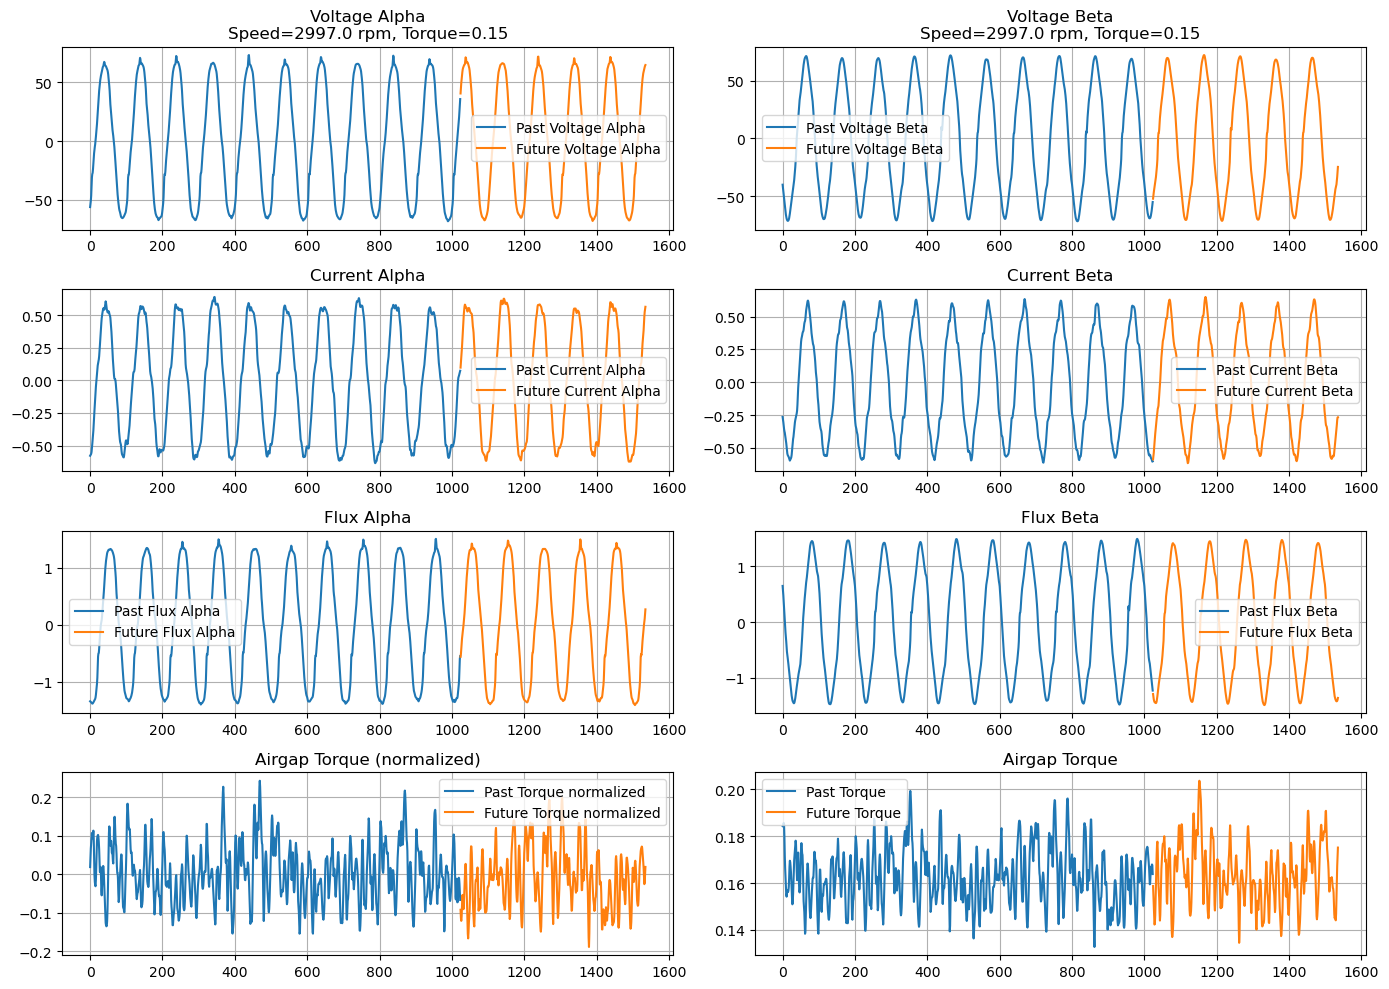

In [96]:
idx = 1  # 可調整索引以觀察不同樣本

def plot_raw_data(idx):
    fig, axs = plt.subplots(4, 2, figsize=(14, 10))
    time_past = np.arange(sequence_length)
    time_future = np.arange(sequence_length, sequence_length + future_length)

    # 取得運轉條件
    speed_val = speed_array_pu[idx, 0] * 3000  # 還原為 rpm
    torque_val = torque_array[idx, 0]

    # 電壓
    axs[0, 0].plot(time_past, past_voltages[idx, :, 0], label='Past Voltage Alpha')
    axs[0, 0].plot(time_future, future_voltages[idx, :, 0], label='Future Voltage Alpha')
    axs[0, 0].set_title(f'Voltage Alpha\nSpeed={speed_val:.1f} rpm, Torque={torque_val:.2f}')
    axs[0, 0].legend()
    axs[0, 0].grid(True)

    axs[0, 1].plot(time_past, past_voltages[idx, :, 1], label='Past Voltage Beta')
    axs[0, 1].plot(time_future, future_voltages[idx, :, 1], label='Future Voltage Beta')
    axs[0, 1].set_title(f'Voltage Beta\nSpeed={speed_val:.1f} rpm, Torque={torque_val:.2f}')
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # 電流
    axs[1, 0].plot(time_past, past_currents[idx, :, 0], label='Past Current Alpha')
    axs[1, 0].plot(time_future, future_currents[idx, :, 0], label='Future Current Alpha')
    axs[1, 0].set_title('Current Alpha')
    axs[1, 0].legend()
    axs[1, 0].grid(True)

    axs[1, 1].plot(time_past, past_currents[idx, :, 1], label='Past Current Beta')
    axs[1, 1].plot(time_future, future_currents[idx, :, 1], label='Future Current Beta')
    axs[1, 1].set_title('Current Beta')
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    # 磁通
    axs[2, 0].plot(time_past, past_emf_normalized[idx, :, 0], label='Past Flux Alpha')
    axs[2, 0].plot(time_future, future_emf_normalized[idx, :, 0], label='Future Flux Alpha')
    axs[2, 0].set_title('Flux Alpha')
    axs[2, 0].legend()
    axs[2, 0].grid(True)

    axs[2, 1].plot(time_past, past_emf_normalized[idx, :, 1], label='Past Flux Beta')
    axs[2, 1].plot(time_future, future_emf_normalized[idx, :, 1], label='Future Flux Beta')
    axs[2, 1].set_title('Flux Beta')
    axs[2, 1].legend()
    axs[2, 1].grid(True)

    # 力矩
    print(past_airgap_torque_normalized.shape)
    axs[3, 0].plot(time_past, past_airgap_torque_normalized[idx, :,0], label='Past Torque normalized')
    axs[3, 0].plot(time_future, future_airgap_torque_normalized[idx, :,0], label='Future Torque normalized')
    axs[3, 0].set_title('Airgap Torque (normalized)')
    axs[3, 0].legend()
    axs[3, 0].grid(True)

    axs[3, 1].plot(time_past, past_airgap_torque[idx, : ,0], label='Past Torque')
    axs[3, 1].plot(time_future, future_airgap_torque[idx, :,0], label='Future Torque')
    axs[3, 1].set_title('Airgap Torque')
    axs[3, 1].legend()
    axs[3, 1].grid(True)

    plt.tight_layout()
    plt.show()
plot_raw_data(idx)

### 訊練 LSTM 模型 ###

Vin Iout

1/1 [==============================] - 1s 1s/step
Model structures passed, start training...
Epoch 1/50
465/465 [==============================] - 50s 82ms/step - loss: 0.0241 - val_loss: 0.0042 - lr: 0.0010
Epoch 2/50
465/465 [==============================] - 38s 81ms/step - loss: 0.0038 - val_loss: 0.0046 - lr: 0.0010
Epoch 3/50
465/465 [==============================] - 38s 81ms/step - loss: 0.0032 - val_loss: 0.0035 - lr: 0.0010
Epoch 4/50
465/465 [==============================] - 38s 82ms/step - loss: 0.0030 - val_loss: 0.0032 - lr: 0.0010
Epoch 5/50
465/465 [==============================] - 38s 82ms/step - loss: 0.0028 - val_loss: 0.0032 - lr: 0.0010
Epoch 6/50
465/465 [==============================] - 38s 81ms/step - loss: 0.0027 - val_loss: 0.0035 - lr: 0.0010
Epoch 7/50
465/465 [==============================] - 38s 82ms/step - loss: 0.0026 - val_loss: 0.0042 - lr: 0.0010
Epoch 8/50
465/465 [==============================] - 38s 83ms/step - loss: 0.0026 - val_loss: 0.0028 

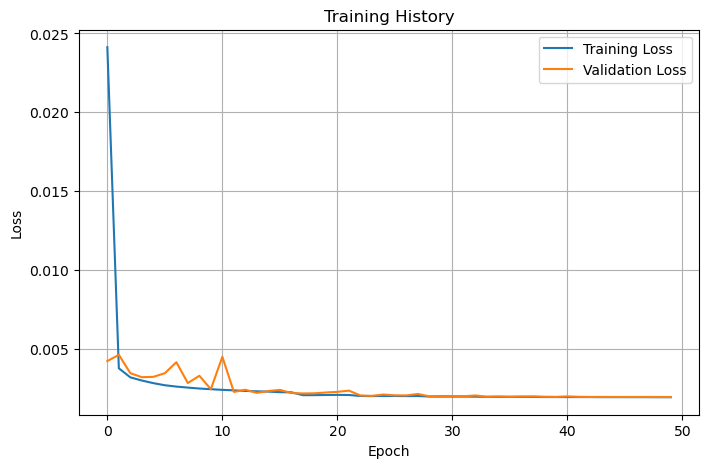

In [97]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# gpus = tf.config.experimental.list_physical_devices('GPU')
# print("GPU devices found:")
# for gpu in gpus:
#     print(gpu)
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#     except RuntimeError as e:
#         print(e)
# from tensorflow.python.client import device_lib
# local_devices = device_lib.list_local_devices()
# for device in local_devices:
#     if device.device_type == 'GPU':
#         print("GPU name:", device.physical_device_desc)
        
def combined_time_freq_loss(y_true, y_pred):
    # 時域 MSE
    mse_time = tf.reduce_mean(tf.square(y_true - y_pred))
    # 頻域 MSE（幅值）
    fft_true = tf.signal.rfft(y_true)
    fft_pred = tf.signal.rfft(y_pred)
    mse_freq = tf.reduce_mean(tf.square(tf.abs(fft_true - fft_pred)))
    # 自訂權重，或動態調整
    return 0.7 * mse_time + 0.3 * mse_freq

def compile_and_prepare_model(model, initial_learning_rate=1e-3):
    
    model.compile(
        optimizer=Adam(learning_rate=initial_learning_rate),
        loss='mse'
    )

    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=10,
        min_delta=1e-6,
        restore_best_weights=True,
        verbose=1
    )
    return lr_scheduler, early_stop

lr_scheduler_flux, early_stop_flux = compile_and_prepare_model(my_model_V_in_I_out)

# 測試模型結構是否正確
my_model_V_in_I_out.predict([ past_emf[0:1,:,:], speed_array_pu[0:1,:], torque_array[0:1,:]])  
#測試模型是否能夠正確讀取
my_model_V_in_I_out.save(os.path.join(model_path, model_name + '_EMF.keras'))
my_model_V_in_I_out= load_model(os.path.join(model_path, model_name + '_EMF.keras'))
print("Model structures passed, start training...")


# # 開始訓練
history_VI = my_model_V_in_I_out.fit(
    x=[past_voltages_normalized, speed_array_pu, torque_array], 
    y=past_currents_normalized,
    batch_size=128,
    epochs=50,
    validation_split=0.1, 
    callbacks=[lr_scheduler_flux, early_stop_flux] 
)

# history_flux = my_model_emf_in_emf_out.fit(
#     x=[past_emf, speed_array_pu, torque_array], 
#     y=future_emf,
#     batch_size=128,
#     epochs=50,
#     validation_split=0.1, 
#     callbacks=[lr_scheduler_flux, early_stop_flux] 
# )

plt.figure(figsize=(8, 5))
plt.plot(history_VI.history['loss'], label='Training Loss')
if 'val_loss' in history_VI.history:
    plt.plot(history_VI.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch') 
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.show()

my_model_V_in_I_out.save(os.path.join(model_path, model_name + '_EMF.keras'))

metadata = {
    "model_name": model_name+'_EMF',
    "sequence_length": sequence_length,
    "layer_number": layer_number,
    "trained": True,
    "train_loss": history_VI.history['loss'][-1],
    "val_loss": history_VI.history.get('val_loss', [None])[-1],
    "train_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
}

with open(os.path.join(model_path, model_name + '_VI_metadata.json'), "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=4)


In [98]:
def list_subfolders(path):
    """列出指定路徑下的所有子資料夾"""
    return [f.path for f in os.scandir(path) if f.is_dir()]

def get_apply_files_data(Normal_subfolders, test_size=0.5):
    # 重採樣次數
    augmen_sample_number=100
    """取得指定工況資料夾下的所有檔案，並分取出部分作驗證"""
    parquet_files = [os.path.join(Normal_subfolders, f) for f in os.listdir(Normal_subfolders) if f.endswith(".parquet")]
    apply_parquet_files, _ = train_test_split(parquet_files, test_size=test_size)
        
    train_signals=[] # vi signals alpha beta 
    train_signals_normalized=[]
    torque_array=[]
    speed_array_pu=[]
   
    
    for file_path in apply_parquet_files:
        if not os.path.exists(file_path):
            print(f"File {file_path} does not exist.")
            continue
        # 讀取資料
        df = read_rul_data(file_path, force_recompute=True)
        if df["Voltage alpha thd"] > 0.1 or df["Voltage beta thd"] > 0.1 or df is None:
            print(f"File {file_path} has high THD, skipping.")
            continue
        current_alpha= np.array(df["Current alpha downsample"])
        current_beta= np.array(df["Current beta downsample"])
        flux_alpha= np.array(df["Flux alpha"])
        flux_beta= np.array(df["Flux beta"])
        if (flux_alpha.shape[0] != current_alpha.shape[0]):
            print(f"File {file_path} has mismatched flux and current lengths, skipping.")
            print(f"flux_alpha length: {flux_alpha.shape[0]}, current_alpha length: {current_alpha.shape[0]}")
            continue
        torque_airgap=1.5*4*(flux_alpha*current_beta-flux_beta*current_alpha)  # 計算 torque
        emf_alpha= (df["Voltage alpha downsample"] - Rs * current_alpha) / (df["Speed"][0] * P * 2 * np.pi / 60)  # 計算電動勢
        emf_beta= (df["Voltage beta downsample"] - Rs * current_beta) / (df["Speed"][0] * P * 2 * np.pi / 60)
        # 標準化
        torque_airgap_normalized = (torque_airgap - np.mean(torque_airgap)) / np.std(torque_airgap)
          
        torque= (df["Torque avg"]) 
        # print(df)
        speed= (df["Speed"][0])
        
        # 合併測試資料至訓練維度 shape=(,4000,dim)
        temp_train_signals = [np.array(df["Voltage alpha downsample"]), 
                              np.array(df["Voltage beta downsample"]),
                              current_alpha,
                              current_beta,
                              flux_alpha,
                              flux_beta,
                              emf_alpha,
                              emf_beta,
                              torque_airgap]
        
        # 將數據正規化到 [-1, 1] 範圍
        temp_train_signals_normalized = []
        # for signal in temp_train_signals:
        #     min_val = np.min(signal)
        #     max_val = np.max(signal)
        #     # 避免除以零的狀況（max == min）
        #     if max_val == min_val:
        #         normalized = np.zeros_like(signal)
        #     else:
        #         normalized = 2 * (signal - min_val) / (max_val - min_val) - 1
        #     temp_train_signals_normalized.append(normalized)
            
        # 將數據標準化（均值為 0，標準差為 1）
        
        for signal in temp_train_signals:
            mean = np.mean(signal)
            std = np.std(signal)
            # 避免除以零的狀況（std == 0）
            if std == 0:
                standardized = np.zeros_like(signal)
            else:
                standardized = (signal - mean) / std
            temp_train_signals_normalized.append(standardized)
        
        
        temp_train_signals_normalized[-1]= torque_airgap_normalized  # 改成std正規化的 torque_airgap
        
        try:
            temp_train_signals = np.stack(temp_train_signals, axis=1)
            temp_train_signals_normalized = np.stack(temp_train_signals_normalized, axis=1)
        except ValueError as e:
            print(f"Error stacking signals for file {file_path}: {e}")
            print(f"datalength {len(df['Voltage alpha downsample'])}")
            continue
        temp_train_input_signals_augmented = data_random_augmentation(temp_train_signals, sequence_length, augmen_sample_number=augmen_sample_number,future_length=future_length)
        temp_train_signals_normalized_augmented = data_random_augmentation(temp_train_signals_normalized, sequence_length, augmen_sample_number=augmen_sample_number,future_length=future_length)
        
        train_signals.append(temp_train_input_signals_augmented)
        train_signals_normalized.append(temp_train_signals_normalized_augmented)
        torque_array.append(np.ones(augmen_sample_number) * torque)
        speed_array_pu.append(np.ones(augmen_sample_number) * speed/3000) # rate 3000 rpm 
        
    train_signals = np.concatenate(train_signals, axis=0).astype(np.float32)
    train_signals_normalized = np.concatenate(train_signals_normalized, axis=0).astype(np.float32)
    torque_array = np.concatenate(torque_array, axis=0).astype(np.float32)
    speed_array_pu = np.concatenate(speed_array_pu, axis=0).astype(np.float32)
    
        
    # 將資料儲存到字典中
    apply_data = {
        "input_signals": train_signals[:, :sequence_length, :],                         # 取前 sequence_length 個時間步長
        "input_signals_normalized": train_signals_normalized[:, :sequence_length, :],   # 取前 sequence_length 個時間步長
        "fit_signals": train_signals[:, -future_length:, :],                            # 取最後 future_length 個時間步長
        "fit_signals_normalized": train_signals_normalized[:, -future_length:, :],      # 取最後 future_length 個時間步長
        "torque_array": torque_array.reshape(-1, 1),
        "speed_array_pu": speed_array_pu.reshape(-1, 1)  # rate 3000 rpm
    }
    return apply_data


# 不同故障重建誤差比對
Consitions=["1200 0.5v", "1200 1.0v", "1200 2.0v",
            "1800 0.5v", "1800 1.0v", "1800 2.0v",
            "3000 0.5v", "3000 1.0v", "3000 2.0v"]

#健康資料集
Normal_data_path= os.path.join(NTU_dataset_path, normal_condition)
Normal_subfolders = list_subfolders(Normal_data_path)
#建立一個字典來儲存每個資料夾的檔案資料與數據
normal_datasets = {}
for folder in Normal_subfolders:
    normal_datasets[folder] = get_apply_files_data(folder)
    
#對照健康資料集
Normal2_data_path= os.path.join(NTU_dataset_path, 'normal-2')
Normal2_subfolders = list_subfolders(Normal2_data_path)
#建立一個字典來儲存每個資料夾的檔案資料與數據
normal2_datasets = {}
for folder in Normal2_subfolders:
    normal2_datasets[folder] = get_apply_files_data(folder)

#異常資料集
Abnormal_data_path = os.path.join(NTU_dataset_path, 'wear-out-2(worse)')
# Abnormal_data_path = os.path.join(NTU_dataset_path, 'drill 2mm 2mm q')
# Abnormal_data_path = os.path.join(NTU_dataset_path, 'cut 2mm')

Abnormal_subfolders = list_subfolders(Abnormal_data_path)    
abnormal_datasets = {}
for folder in Abnormal_subfolders:
    abnormal_datasets[folder] = get_apply_files_data(folder)


Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalc

In [99]:
print(Normal_subfolders)
print(Normal2_subfolders)
print(Abnormal_subfolders)

['D:\\OneDrive\\CCAE_experiments\\CCAE_datasets2\\normal-1\\normal-1 1200 0.5v  2kg cm2', 'D:\\OneDrive\\CCAE_experiments\\CCAE_datasets2\\normal-1\\normal-1 1200 1.0v  2kg cm2', 'D:\\OneDrive\\CCAE_experiments\\CCAE_datasets2\\normal-1\\normal-1 1200 2.0v  2kg cm2', 'D:\\OneDrive\\CCAE_experiments\\CCAE_datasets2\\normal-1\\normal-1 1800 0.5v  2kg cm2', 'D:\\OneDrive\\CCAE_experiments\\CCAE_datasets2\\normal-1\\normal-1 1800 1.0v  2kg cm2', 'D:\\OneDrive\\CCAE_experiments\\CCAE_datasets2\\normal-1\\normal-1 1800 2.0v  2kg cm2', 'D:\\OneDrive\\CCAE_experiments\\CCAE_datasets2\\normal-1\\normal-1 3000 0.5v  2kg cm2', 'D:\\OneDrive\\CCAE_experiments\\CCAE_datasets2\\normal-1\\normal-1 3000 1.0v  2kg cm2', 'D:\\OneDrive\\CCAE_experiments\\CCAE_datasets2\\normal-1\\normal-1 3000 2.0v  2kg cm2']
['D:\\OneDrive\\CCAE_experiments\\CCAE_datasets2\\normal-2\\normal-2 1200 0.5v  2kg cm2', 'D:\\OneDrive\\CCAE_experiments\\CCAE_datasets2\\normal-2\\normal-2 1200 1.0v  2kg cm2', 'D:\\OneDrive\\CCAE

8/8 [==============================] - 0s 27ms/step


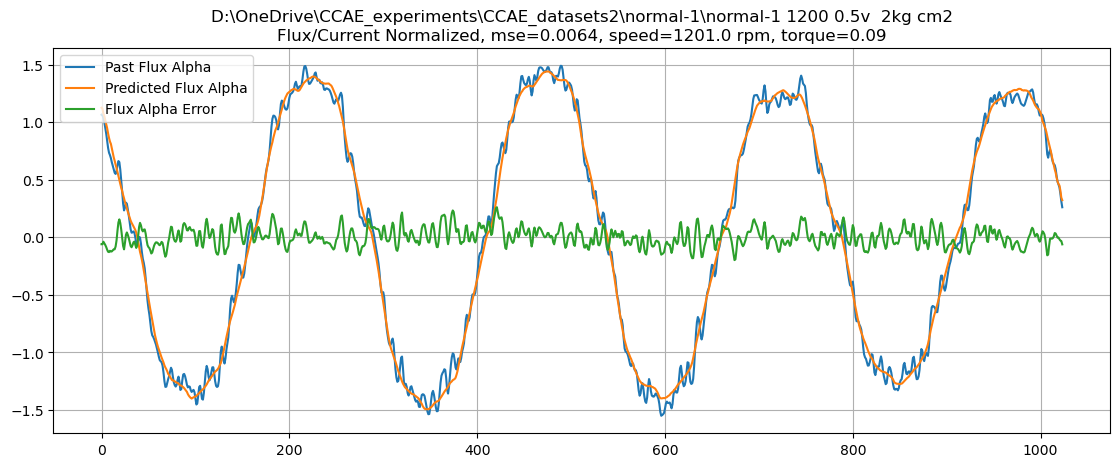

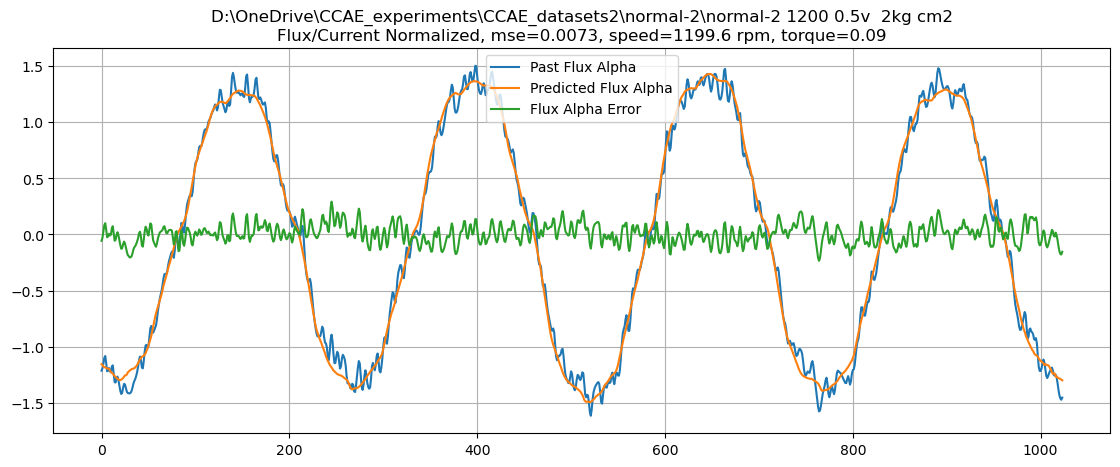

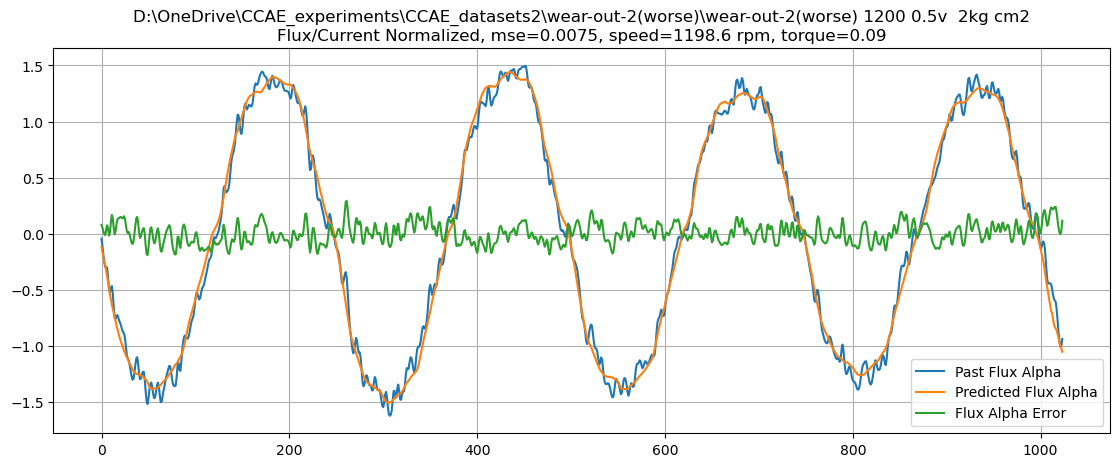

In [109]:
# --- 參數 ---
condition_number = 0   # 保持你原本的設定
idx = 0                # 用來在標題顯示第 idx 筆的速度/扭矩；若已有外部 idx 可刪除這行

# --- Normal ---
check_past_emf_normal = normal_datasets[Normal_subfolders[condition_number]]["input_signals_normalized"][:, :, 0:2]  # 過去 emf
check_past_current_normal = normal_datasets[Normal_subfolders[condition_number]]["input_signals_normalized"][:, :, 2:4]  # 過去 current（僅用於比較/誤差）
check_reconstruction_normal = my_model_V_in_I_out.predict(
    [check_past_emf_normal,
     normal_datasets[Normal_subfolders[condition_number]]["speed_array_pu"],
     normal_datasets[Normal_subfolders[condition_number]]["torque_array"]],
    batch_size=128
)

# --- Normal2（新增） ---
check_past_emf_normal2 = normal2_datasets[Normal2_subfolders[condition_number]]["input_signals_normalized"][:, :, 0:2]
check_past_current_normal2 = normal2_datasets[Normal2_subfolders[condition_number]]["input_signals_normalized"][:, :, 2:4]
check_reconstruction_normal2 = my_model_V_in_I_out.predict(
    [check_past_emf_normal2,
     normal2_datasets[Normal2_subfolders[condition_number]]["speed_array_pu"],
     normal2_datasets[Normal2_subfolders[condition_number]]["torque_array"]],
    batch_size=128
)

# --- Abnormal ---
check_past_emf_abnormal = abnormal_datasets[Abnormal_subfolders[condition_number]]["input_signals_normalized"][:, :, 0:2]
check_past_current_abnormal = abnormal_datasets[Abnormal_subfolders[condition_number]]["input_signals_normalized"][:, :, 2:4]
check_reconstruction_abnormal = my_model_V_in_I_out.predict(
    [check_past_emf_abnormal,
     abnormal_datasets[Abnormal_subfolders[condition_number]]["speed_array_pu"],
     abnormal_datasets[Abnormal_subfolders[condition_number]]["torque_array"]],
    batch_size=128
)

# --- Plot: NORMAL ---
plt.figure(figsize=(30, 5))
plt.subplot(1, 2, 1)
plt.plot(range(sequence_length), check_past_current_normal[0, :, 0], label='Past Flux Alpha')
plt.plot(range(sequence_length), check_reconstruction_normal[0, :, 0], label='Predicted Flux Alpha')
error = check_past_current_normal[0, :, 0] - check_reconstruction_normal[0, :, 0]
plt.plot(range(sequence_length), error, label='Flux Alpha Error')
plt.title(
    f'{Normal_subfolders[condition_number]}\n'
    f'Flux/Current Normalized, mse={np.mean(np.square(error)):.4f}, '
    f'speed={normal_datasets[Normal_subfolders[condition_number]]["speed_array_pu"][idx, 0]*3000:.1f} rpm, '
    f'torque={normal_datasets[Normal_subfolders[condition_number]]["torque_array"][idx, 0]:.2f}'
)
plt.legend()
plt.grid(True)

# --- Plot: NORMAL2 ---
plt.figure(figsize=(30, 5))
plt.subplot(1, 2, 1)
plt.plot(range(sequence_length), check_past_current_normal2[0, :, 0], label='Past Flux Alpha')
plt.plot(range(sequence_length), check_reconstruction_normal2[0, :, 0], label='Predicted Flux Alpha')
error = check_past_current_normal2[0, :, 0] - check_reconstruction_normal2[0, :, 0]
plt.plot(range(sequence_length), error, label='Flux Alpha Error')
plt.title(
    f'{Normal2_subfolders[condition_number]}\n'
    f'Flux/Current Normalized, mse={np.mean(np.square(error)):.4f}, '
    f'speed={normal2_datasets[Normal2_subfolders[condition_number]]["speed_array_pu"][idx, 0]*3000:.1f} rpm, '
    f'torque={normal2_datasets[Normal2_subfolders[condition_number]]["torque_array"][idx, 0]:.2f}'
)
plt.legend()
plt.grid(True)

# --- Plot: ABNORMAL ---
plt.figure(figsize=(30, 5))
plt.subplot(1, 2, 1)
plt.plot(range(sequence_length), check_past_current_abnormal[0, :, 0], label='Past Flux Alpha')
plt.plot(range(sequence_length), check_reconstruction_abnormal[0, :, 0], label='Predicted Flux Alpha')
error = check_past_current_abnormal[0, :, 0] - check_reconstruction_abnormal[0, :, 0]
plt.plot(range(sequence_length), error, label='Flux Alpha Error')
plt.title(
    f'{Abnormal_subfolders[condition_number]}\n'
    f'Flux/Current Normalized, mse={np.mean(np.square(error)):.4f}, '
    f'speed={abnormal_datasets[Abnormal_subfolders[condition_number]]["speed_array_pu"][idx, 0]*3000:.1f} rpm, '
    f'torque={abnormal_datasets[Abnormal_subfolders[condition_number]]["torque_array"][idx, 0]:.2f}'
)
plt.legend()
plt.grid(True)


9/9 [==============================] - 0s 25ms/step
Condition: 1200 0.5v, Normal Key: D:\OneDrive\CCAE_experiments\CCAE_datasets2\normal-1\normal-1 1200 0.5v  2kg cm2, Normal2 Key: D:\OneDrive\CCAE_experiments\CCAE_datasets2\normal-2\normal-2 1200 0.5v  2kg cm2, Abnormal Key: D:\OneDrive\CCAE_experiments\CCAE_datasets2\wear-out-2(worse)\wear-out-2(worse) 1200 0.5v  2kg cm2
Condition: 1200 1.0v, Normal Key: D:\OneDrive\CCAE_experiments\CCAE_datasets2\normal-1\normal-1 1200 1.0v  2kg cm2, Normal2 Key: D:\OneDrive\CCAE_experiments\CCAE_datasets2\normal-2\normal-2 1200 1.0v  2kg cm2, Abnormal Key: D:\OneDrive\CCAE_experiments\CCAE_datasets2\wear-out-2(worse)\wear-out-2(worse) 1200 1.0v  2kg cm2
Condition: 1200 2.0v, Normal Key: D:\OneDrive\CCAE_experiments\CCAE_datasets2\normal-1\normal-1 1200 2.0v  2kg cm2, Normal2 Key: D:\OneDrive\CCAE_experiments\CCAE_datasets2\normal-2\normal-2 1200 2.0v  2kg cm2, Abnormal Key: D:\OneDrive\CCAE_experiments\CCAE_datasets2\wear-out-2(worse)\wear-out-2(wo

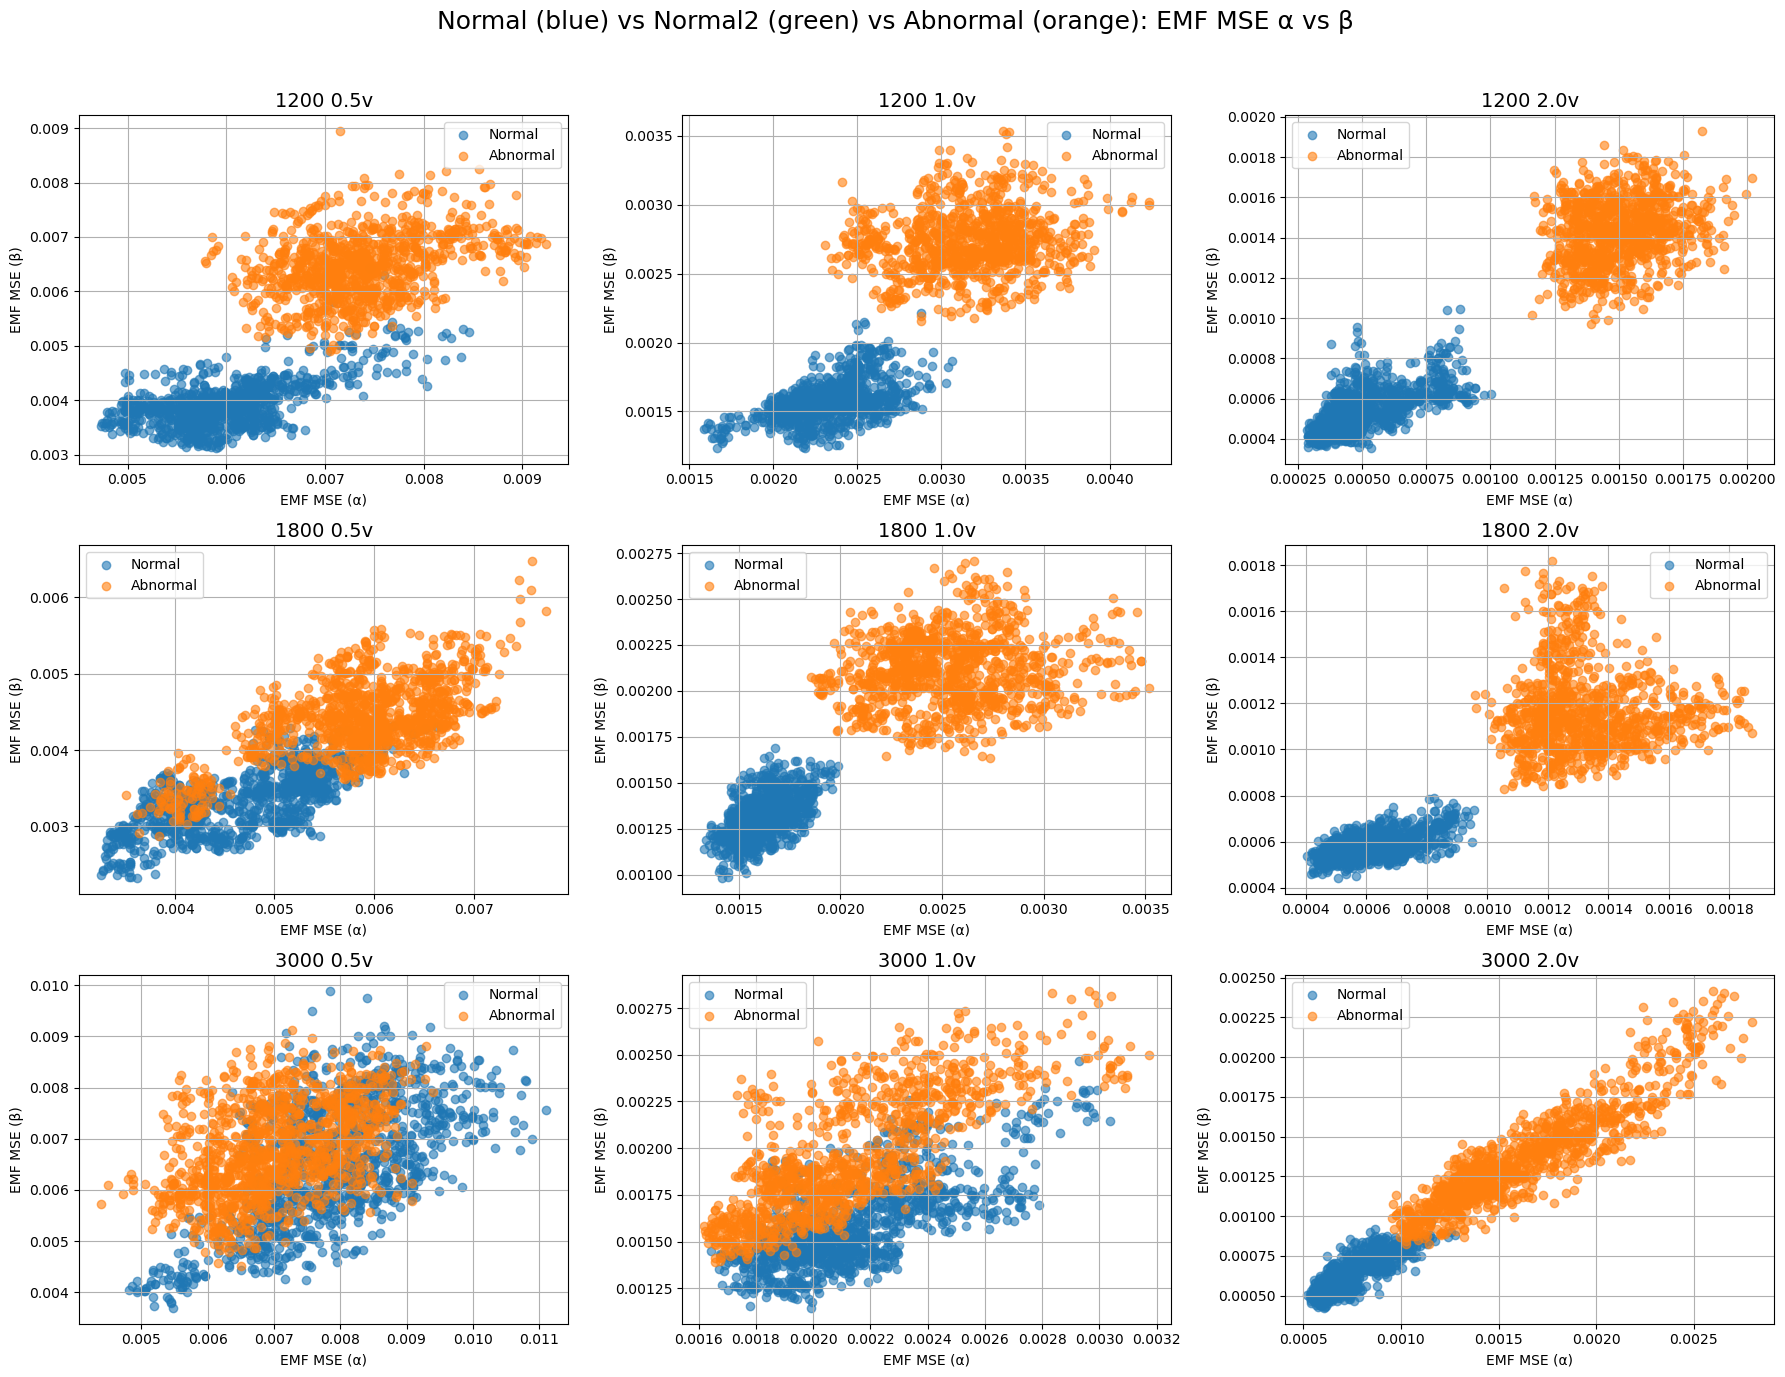

In [106]:

#計算重建MSE資料
normal_reconstruction_errors_VI = {}
for folder in Normal_subfolders:
    past_voltage_normalized= normal_datasets[folder]["input_signals_normalized"][:, :, 0:2]  # 使用過去的 emf 作為輸入
    future_current_normalized= normal_datasets[folder]["input_signals_normalized"][:, :, 2:4]
    # print(future_current_normalized.shape)
    reconstruction_errors_flux=my_model_V_in_I_out.predict(
        [past_voltage_normalized, 
        normal_datasets[folder]["speed_array_pu"], 
        normal_datasets[folder]["torque_array"]],
        batch_size=128)
    reconstruction_MSEs_flux_alpha = np.mean((future_current_normalized[:,:,0] - reconstruction_errors_flux[:,:,0])**2,axis=(1))
    reconstruction_MSEs_flux_beta = np.mean((future_current_normalized[:,:,1] - reconstruction_errors_flux[:,:,1])**2,axis=(1))
    normal_reconstruction_errors_VI[folder] = {"EMF_alpha_MSE": reconstruction_MSEs_flux_alpha,
                                                 "EMF_beta_MSE": reconstruction_MSEs_flux_beta}
    
normal2_reconstruction_errors_VI = {}
for folder in Normal2_subfolders:
    past_voltage_normalized= normal2_datasets[folder]["input_signals_normalized"][:, :, 0:2]  # 使用過去的 emf 作為輸入
    future_current_normalized= normal2_datasets[folder]["input_signals_normalized"][:, :, 2:4]
    # print(future_current_normalized.shape)
    reconstruction_errors_flux=my_model_V_in_I_out.predict(
        [past_voltage_normalized, 
        normal2_datasets[folder]["speed_array_pu"], 
        normal2_datasets[folder]["torque_array"]],
        batch_size=128)
    reconstruction_MSEs_flux_alpha = np.mean((future_current_normalized[:,:,0] - reconstruction_errors_flux[:,:,0])**2,axis=(1))
    reconstruction_MSEs_flux_beta = np.mean((future_current_normalized[:,:,1] - reconstruction_errors_flux[:,:,1])**2,axis=(1))
    normal2_reconstruction_errors_VI[folder] = {"EMF_alpha_MSE": reconstruction_MSEs_flux_alpha,
                                                 "EMF_beta_MSE": reconstruction_MSEs_flux_beta}

abnormal_reconstruction_errors_VI = {}
for folder in Abnormal_subfolders:
    past_voltage_normalized= abnormal_datasets[folder]["input_signals_normalized"][:, :, 0:2] 
    future_current_normalized= abnormal_datasets[folder]["input_signals_normalized"][:, :, 2:4]
    reconstruction_errors_flux=my_model_V_in_I_out.predict(
        [past_voltage_normalized, 
        abnormal_datasets[folder]["speed_array_pu"], 
        abnormal_datasets[folder]["torque_array"]],
        batch_size=128)
    reconstruction_MSEs_flux_alpha = np.mean((future_current_normalized[:,:,0] - reconstruction_errors_flux[:,:,0])**2,axis=(1))
    reconstruction_MSEs_flux_beta = np.mean((future_current_normalized[:,:,1] - reconstruction_errors_flux[:,:,1])**2,axis=(1))
    abnormal_reconstruction_errors_VI[folder] = {"EMF_alpha_MSE": reconstruction_MSEs_flux_alpha,
                                                 "EMF_beta_MSE": reconstruction_MSEs_flux_beta}

# 畫出兩者間的分布圖
# Step 0: 定義 Condition Map
Condition_map = {
    '1200 0.5v': 'Condition 1',
    '1200 1.0v': 'Condition 2',
    '1200 2.0v': 'Condition 3',
    '1800 0.5v': 'Condition 4',
    '1800 1.0v': 'Condition 5',
    '1800 2.0v': 'Condition 6',
    '3000 0.5v': 'Condition 7',
    '3000 1.0v': 'Condition 8',
    '3000 2.0v': 'Condition 9',
}

# print(abnormal_reconstruction_errors_VI.items())


# Step 1: 遍歷 Condition_map，確保三種資料都有對應 key
matched_conditions = []
for cond_key in Condition_map:
    normal_key  = next((k for k in normal_reconstruction_errors_VI  if cond_key in k), None)
    normal2_key = next((k for k in normal2_reconstruction_errors_VI if cond_key in k), None)
    abnormal_key = next((k for k in abnormal_reconstruction_errors_VI if cond_key in k), None)

    print(f"Condition: {cond_key}, Normal Key: {normal_key}, Normal2 Key: {normal2_key}, Abnormal Key: {abnormal_key}")
    
    if normal_key and normal2_key and abnormal_key:
        matched_conditions.append((cond_key, normal_key, normal2_key, abnormal_key))

# Step 2: 畫圖（散點圖）
num_folders = len(matched_conditions)
num_figs = int(np.ceil(num_folders / 9))

for fig_idx in range(num_figs):
    fig, axes = plt.subplots(3, 3, figsize=(18, 14))
    fig.suptitle("Normal (blue) vs Normal2 (green) vs Abnormal (orange): EMF MSE α vs β", fontsize=18)

    for i in range(9):
        cond_idx = fig_idx * 9 + i
        if cond_idx >= num_folders:
            axes.flat[i].set_visible(False)
            continue

        cond_key, normal_key, normal2_key, abnormal_key = matched_conditions[cond_idx]
        ax = axes.flat[i]

        # Normal
        x_normal = normal_reconstruction_errors_VI[normal_key]["EMF_alpha_MSE"]
        y_normal = normal_reconstruction_errors_VI[normal_key]["EMF_beta_MSE"]

        # Normal2
        x_normal2 = normal2_reconstruction_errors_VI[normal2_key]["EMF_alpha_MSE"]
        y_normal2 = normal2_reconstruction_errors_VI[normal2_key]["EMF_beta_MSE"]

        # Abnormal
        x_abnormal = abnormal_reconstruction_errors_VI[abnormal_key]["EMF_alpha_MSE"]
        y_abnormal = abnormal_reconstruction_errors_VI[abnormal_key]["EMF_beta_MSE"]

        # 畫散點
        ax.scatter(x_normal,  y_normal,  label="Normal",  color='tab:blue',  alpha=0.6)
        # ax.scatter(x_normal2, y_normal2, label="Normal2", color='tab:green', alpha=0.6)
        ax.scatter(x_abnormal,y_abnormal,label="Abnormal",color='tab:orange',alpha=0.6)

        ax.set_xlabel("EMF MSE (α)")
        ax.set_ylabel("EMF MSE (β)")
        ax.set_title(cond_key, fontsize=14)
        ax.grid(True)
        ax.legend(loc="best")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

### 3. 電流 in 電流 out ###
訓練

GPU devices found:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1/1 [==============================] - 1s 1s/step
Model structures passed, start training...
Epoch 1/50
233/233 [==============================] - 42s 133ms/step - loss: 0.0473 - val_loss: 0.0040 - lr: 0.0010
Epoch 2/50
233/233 [==============================] - 30s 129ms/step - loss: 0.0033 - val_loss: 0.0032 - lr: 0.0010
Epoch 3/50
233/233 [==============================] - 30s 129ms/step - loss: 0.0027 - val_loss: 0.0026 - lr: 0.0010
Epoch 4/50
233/233 [==============================] - 30s 129ms/step - loss: 0.0025 - val_loss: 0.0024 - lr: 0.0010
Epoch 5/50
233/233 [==============================] - 30s 129ms/step - loss: 0.0024 - val_loss: 0.0022 - lr: 0.0010
Epoch 6/50
233/233 [==============================] - 30s 129ms/step - loss: 0.0023 - val_loss: 0.0023 - lr: 0.0010
Epoch 7/50
233/233 [==============================] - 30s 130ms/step - loss: 0.0022 - val_loss: 0.0023 - lr: 0.0010
Epoch 8/50


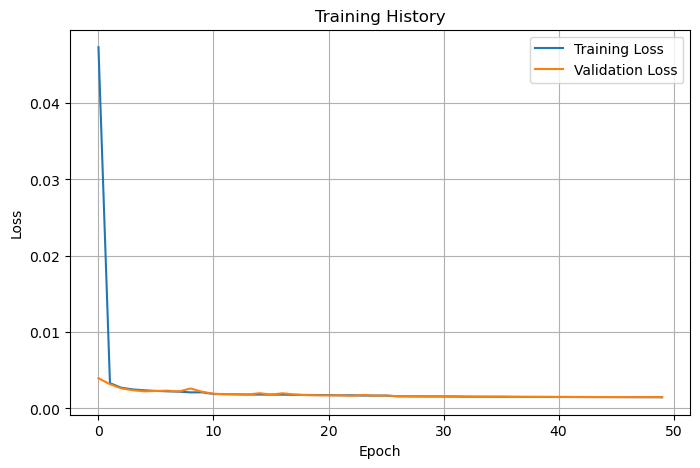

In [102]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

gpus = tf.config.experimental.list_physical_devices('GPU')
print("GPU devices found:")
for gpu in gpus:
    print(gpu)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


def compile_and_prepare_model(model, initial_learning_rate=1e-3):
    
    model.compile(
        optimizer=Adam(learning_rate=initial_learning_rate),
        loss='mse'
    )

    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=10,
        min_delta=0.00001,
        restore_best_weights=True,
        verbose=1
    )
    return lr_scheduler, early_stop

lr_scheduler_I, early_stop_I = compile_and_prepare_model(my_model_I_in_I_out)

my_model_I_in_I_out.predict([past_currents_normalized[0:1,:,:], speed_array_pu[0:1,:], torque_array[0:1,:]])
print("Model structures passed, start training...")

# 開始訓練
#nromalized version
history_I = my_model_I_in_I_out.fit(
    x=[past_currents_normalized, speed_array_pu, torque_array], 
    y=past_currents_normalized,
    batch_size=256,
    epochs=50,
    validation_split=0.1, 
    callbacks=[lr_scheduler_I, early_stop_I] 
)

plt.figure(figsize=(8, 5))
plt.plot(history_I.history['loss'], label='Training Loss')
if 'val_loss' in history_I.history:
    plt.plot(history_I.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch') 
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.show()

metadata = {
    "model_name": model_name+'_I',
    "sequence_length": sequence_length,
    "layer_number": layer_number,
    "trained": True,
    "train_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
}

with open(os.path.join(model_path, model_name + '_I_metadata.json'), "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=4)
    

# 儲存模型    
my_model_I_in_I_out.save(os.path.join(model_path, model_name + '_I.keras'))


結果展示

9/9 [==============================] - 0s 26ms/step


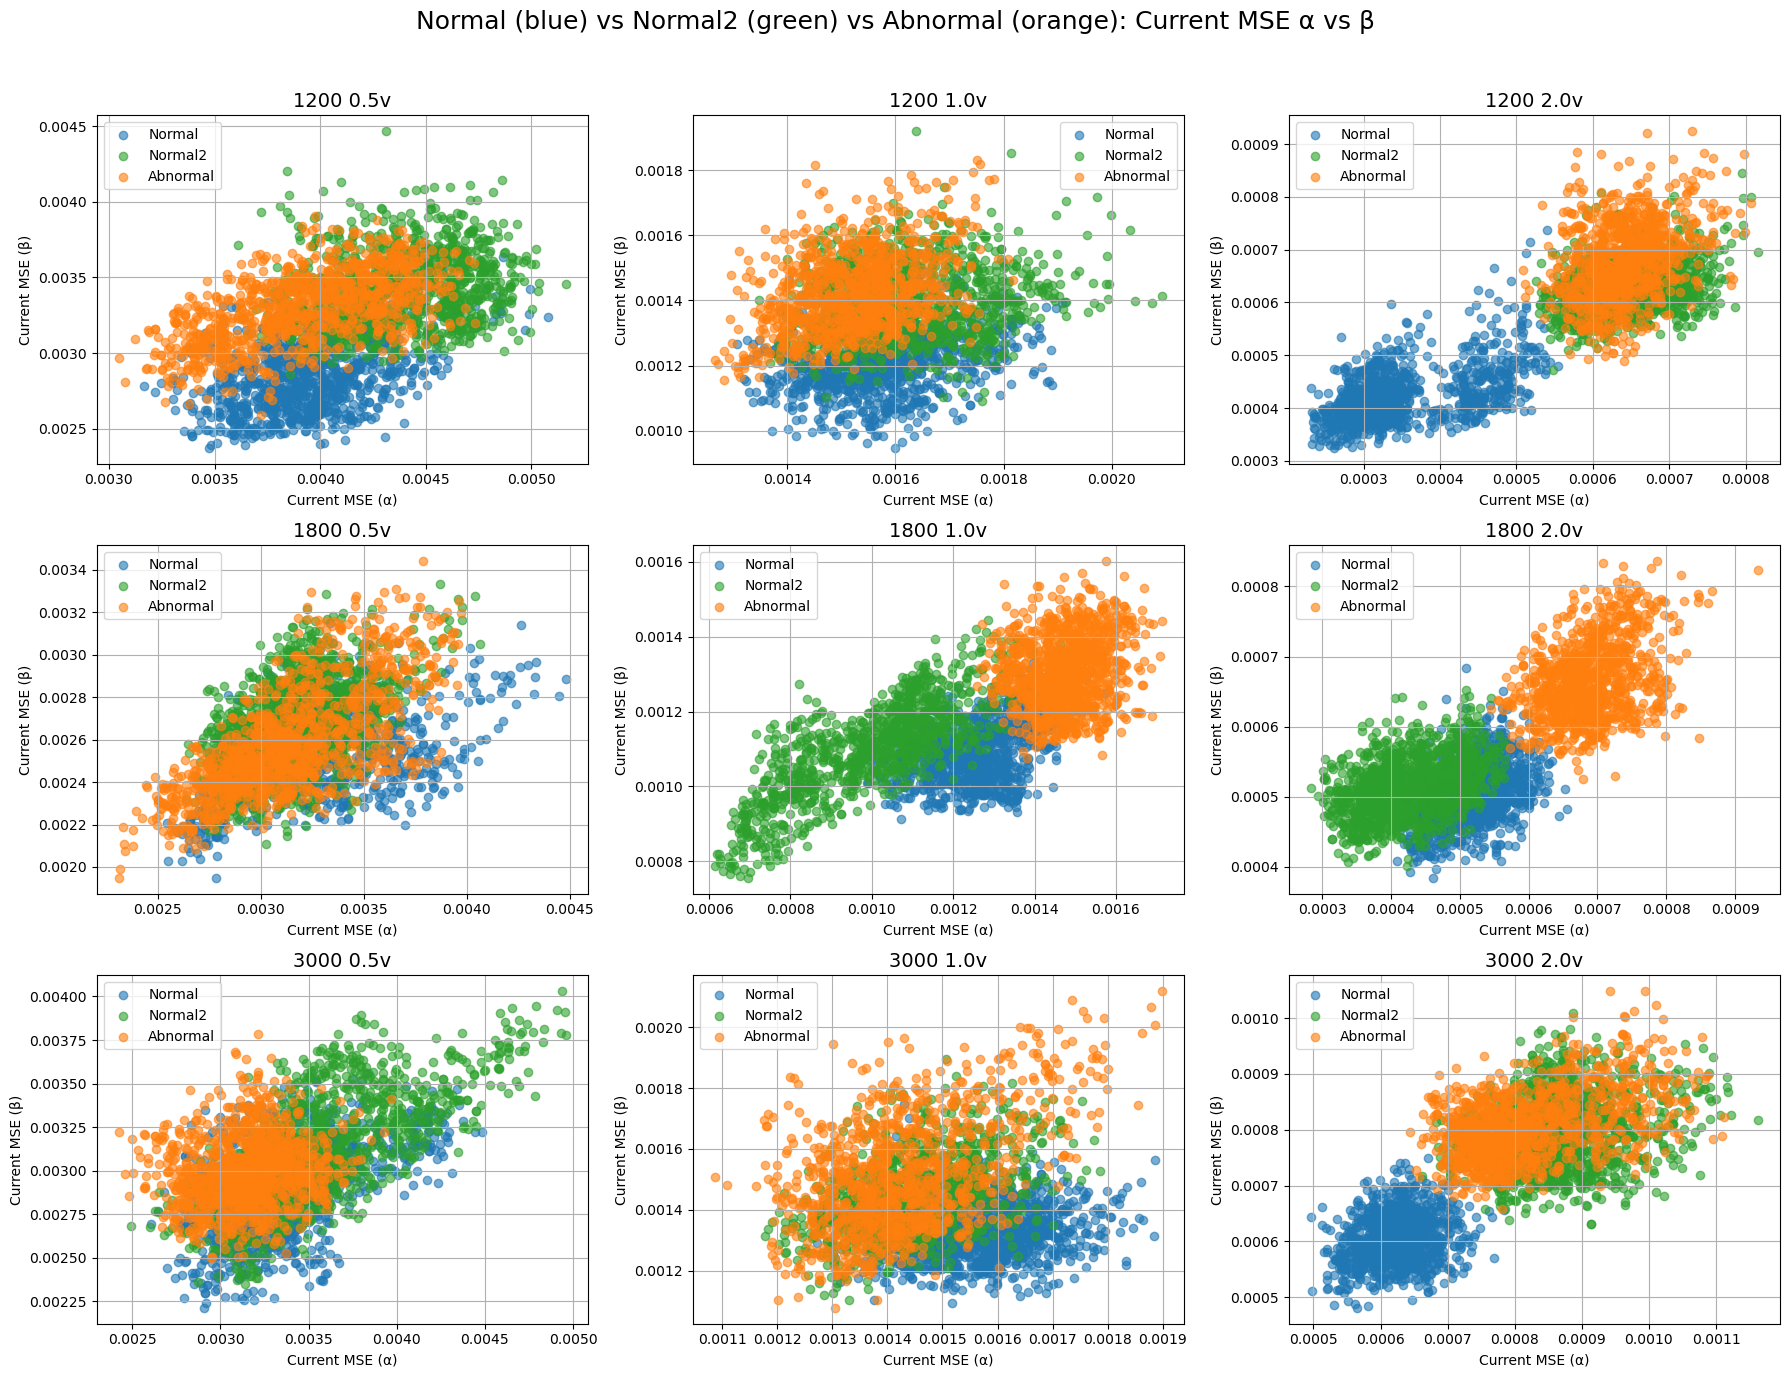

In [103]:
# 畫出兩者間的分布圖（散點）
# Step 0: 定義 Condition Map
Condition_map = {
    '1200 0.5v': 'Condition 1',
    '1200 1.0v': 'Condition 2',
    '1200 2.0v': 'Condition 3',
    '1800 0.5v': 'Condition 4',
    '1800 1.0v': 'Condition 5',
    '1800 2.0v': 'Condition 6',
    '3000 0.5v': 'Condition 7',
    '3000 1.0v': 'Condition 8',
    '3000 2.0v': 'Condition 9',
}

# 計算重建MSE資料
normal_reconstruction_errors_current = {}
for folder in Normal_subfolders:
    recon = my_model_I_in_I_out.predict(
        [normal_datasets[folder]["input_signals_normalized"][:, :, 2:4],
         normal_datasets[folder]["speed_array_pu"],
         normal_datasets[folder]["torque_array"]],
        batch_size=128
    )
    mse_per_sample = np.mean((recon - normal_datasets[folder]["input_signals_normalized"][:, :, 2:4]) ** 2, axis=1)
    normal_reconstruction_errors_current[folder] = {
        "Current_MSE_alpha": mse_per_sample[:, 0],
        "Current_MSE_beta": mse_per_sample[:, 1]
    }

normal2_reconstruction_errors_current = {}
for folder in Normal2_subfolders:
    recon = my_model_I_in_I_out.predict(
        [normal2_datasets[folder]["input_signals_normalized"][:, :, 2:4],
         normal2_datasets[folder]["speed_array_pu"],
         normal2_datasets[folder]["torque_array"]],
        batch_size=128
    )
    mse_per_sample = np.mean((recon - normal2_datasets[folder]["input_signals_normalized"][:, :, 2:4]) ** 2, axis=1)
    normal2_reconstruction_errors_current[folder] = {
        "Current_MSE_alpha": mse_per_sample[:, 0],
        "Current_MSE_beta": mse_per_sample[:, 1]
    }

abnormal_reconstruction_errors_current = {}
for folder in Abnormal_subfolders:
    recon = my_model_I_in_I_out.predict(
        [abnormal_datasets[folder]["input_signals_normalized"][:, :, 2:4],
         abnormal_datasets[folder]["speed_array_pu"],
         abnormal_datasets[folder]["torque_array"]],
        batch_size=128
    )
    mse_per_sample = np.mean((recon - abnormal_datasets[folder]["input_signals_normalized"][:, :, 2:4]) ** 2, axis=1)
    abnormal_reconstruction_errors_current[folder] = {
        "Current_MSE_alpha": mse_per_sample[:, 0],
        "Current_MSE_beta": mse_per_sample[:, 1]
    }

# Step 2: 遍歷 Condition_map，為三個 dict 都找到 key 才算配對成功
matched_conditions = []
for cond_key in Condition_map:
    normal_key  = next((k for k in normal_reconstruction_errors_current  if cond_key in k), None)
    normal2_key = next((k for k in normal2_reconstruction_errors_current if cond_key in k), None)
    abnormal_key = next((k for k in abnormal_reconstruction_errors_current if cond_key in k), None)
    if normal_key and normal2_key and abnormal_key:
        matched_conditions.append((cond_key, normal_key, normal2_key, abnormal_key))

# Step 3: 畫圖（散點）
num_folders = len(matched_conditions)
num_figs = int(np.ceil(num_folders / 9))

for fig_idx in range(num_figs):
    fig, axes = plt.subplots(3, 3, figsize=(18, 14))
    fig.suptitle("Normal (blue) vs Normal2 (green) vs Abnormal (orange): Current MSE α vs β", fontsize=18)

    for i in range(9):
        cond_idx = fig_idx * 9 + i
        if cond_idx >= num_folders:
            axes.flat[i].set_visible(False)
            continue

        cond_key, normal_key, normal2_key, abnormal_key = matched_conditions[cond_idx]
        ax = axes.flat[i]

        # Normal
        x_normal = normal_reconstruction_errors_current[normal_key]["Current_MSE_alpha"]
        y_normal = normal_reconstruction_errors_current[normal_key]["Current_MSE_beta"]

        # Normal2
        x_normal2 = normal2_reconstruction_errors_current[normal2_key]["Current_MSE_alpha"]
        y_normal2 = normal2_reconstruction_errors_current[normal2_key]["Current_MSE_beta"]

        # Abnormal
        x_abnormal = abnormal_reconstruction_errors_current[abnormal_key]["Current_MSE_alpha"]
        y_abnormal = abnormal_reconstruction_errors_current[abnormal_key]["Current_MSE_beta"]

        # 畫散點
        ax.scatter(x_normal,  y_normal,  label="Normal",  color='tab:blue',  alpha=0.6)
        ax.scatter(x_normal2, y_normal2, label="Normal2", color='tab:green', alpha=0.6)
        ax.scatter(x_abnormal,y_abnormal,label="Abnormal",color='tab:orange',alpha=0.6)

        ax.set_xlabel("Current MSE (α)")
        ax.set_ylabel("Current MSE (β)")
        ax.set_title(cond_key, fontsize=14)
        ax.grid(True)
        ax.legend(loc="best")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


3/8 [==========>...................] - ETA: 0s

8/8 [==============================] - 0s 26ms/step


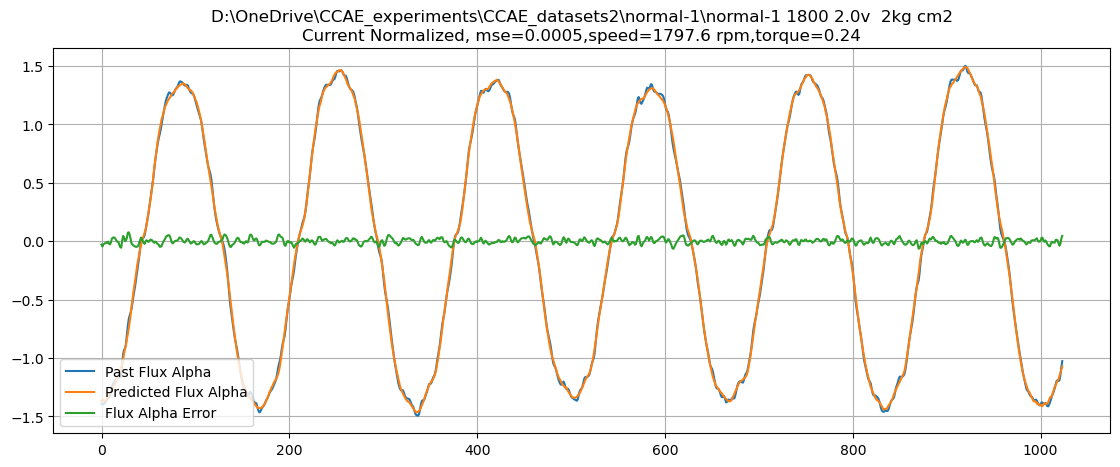

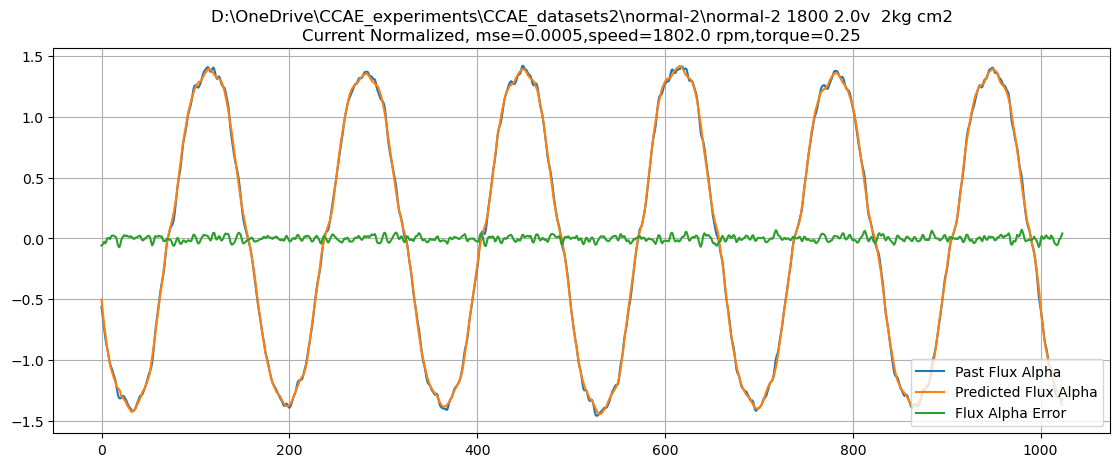

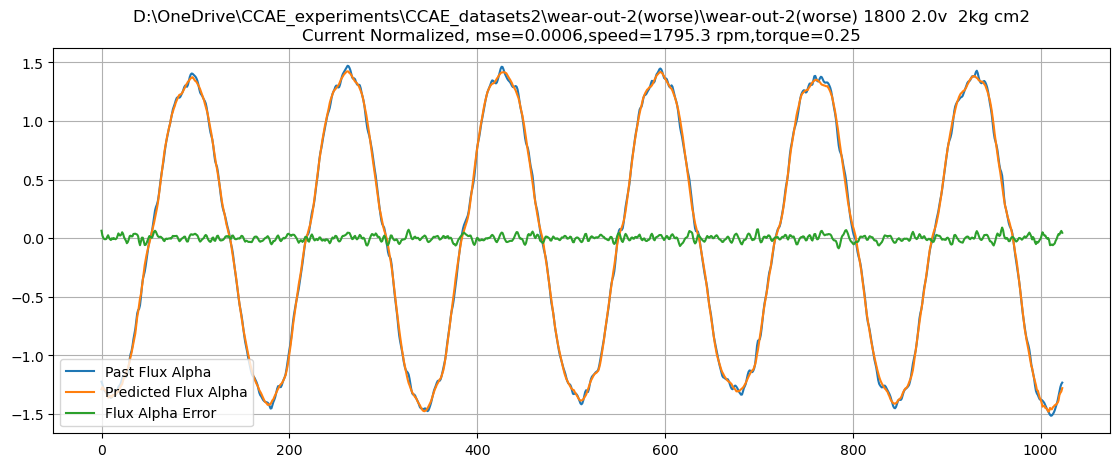

In [104]:
condition_number=5

check_past_emf_normal= normal_datasets[Normal_subfolders[condition_number]]["input_signals_normalized"][:, :, 2:4]  # 使用過去的 emf 作為輸入
check_reconstruction_normal=my_model_I_in_I_out.predict(
    [check_past_emf_normal, 
    normal_datasets[Normal_subfolders[condition_number]]["speed_array_pu"], 
    normal_datasets[Normal_subfolders[condition_number]]["torque_array"]],
    batch_size=128)

check_past_emf_normal2= normal2_datasets[Normal2_subfolders[condition_number]]["input_signals_normalized"][:, :, 2:4]  # 使用過去的 emf 作為輸入
check_reconstruction_normal2=my_model_I_in_I_out.predict(
    [check_past_emf_normal2, 
    normal2_datasets[Normal2_subfolders[condition_number]]["speed_array_pu"], 
    normal2_datasets[Normal2_subfolders[condition_number]]["torque_array"]],
    batch_size=128)

check_past_emf_abnormal= abnormal_datasets[Abnormal_subfolders[condition_number]]["input_signals_normalized"][:, :, 2:4]  # 使用過去的 emf 作為輸入
check_reconstruction_abnormal=my_model_I_in_I_out.predict(
    [check_past_emf_abnormal, 
    abnormal_datasets[Abnormal_subfolders[condition_number]]["speed_array_pu"], 
    abnormal_datasets[Abnormal_subfolders[condition_number]]["torque_array"]],
    batch_size=128)

plt.figure(figsize=(30, 5))
plt.subplot(1, 2, 1)
plt.plot(range(sequence_length),check_past_emf_normal[0, :, 0], label='Past Flux Alpha')
plt.plot(range(sequence_length),check_reconstruction_normal[0,:, 0], label='Predicted Flux Alpha')
error= check_past_emf_normal[0, :, 0]-check_reconstruction_normal[0,:, 0]
plt.plot(range(sequence_length),error, label='Flux Alpha Error')
plt.title(  f'{Normal_subfolders[condition_number]}\n'
            f'Current Normalized, mse={np.mean(np.square(error)):.4f},'   
            f'speed={normal_datasets[Normal_subfolders[condition_number]]["speed_array_pu"][idx, 0]*3000:.1f} rpm,'
            f'torque={normal_datasets[Normal_subfolders[condition_number]]["torque_array"][idx, 0]:.2f}')
plt.legend()
plt.grid(True)


plt.figure(figsize=(30, 5))
plt.subplot(1, 2, 1)
plt.plot(range(sequence_length),check_past_emf_normal2[0, :, 0], label='Past Flux Alpha')
plt.plot(range(sequence_length),check_reconstruction_normal2[0,:, 0], label='Predicted Flux Alpha')
error= check_past_emf_normal2[0, :, 0]-check_reconstruction_normal2[0,:, 0]
plt.plot(range(sequence_length),error, label='Flux Alpha Error')
plt.title(  f'{Normal2_subfolders[condition_number]}\n'
            f'Current Normalized, mse={np.mean(np.square(error)):.4f},'   
            f'speed={normal2_datasets[Normal2_subfolders[condition_number]]["speed_array_pu"][idx, 0]*3000:.1f} rpm,'
            f'torque={normal2_datasets[Normal2_subfolders[condition_number]]["torque_array"][idx, 0]:.2f}')
plt.legend()
plt.grid(True)

plt.figure(figsize=(30, 5))
plt.subplot(1, 2, 1)
plt.plot(range(sequence_length),check_past_emf_abnormal[0, :, 0], label='Past Flux Alpha')
plt.plot(range(sequence_length),check_reconstruction_abnormal[0,:, 0], label='Predicted Flux Alpha')
error= check_past_emf_abnormal[0, :, 0]-check_reconstruction_abnormal[0,:, 0]
plt.plot(range(sequence_length),error, label='Flux Alpha Error')
plt.title(f'{Abnormal_subfolders[condition_number]}\n'
    f'Current Normalized, mse={np.mean(np.square(error)):.4f},'   
          f'speed={abnormal_datasets[Abnormal_subfolders[condition_number]]["speed_array_pu"][idx, 0]*3000:.1f} rpm,'
          f'torque={abnormal_datasets[Abnormal_subfolders[condition_number]]["torque_array"][idx, 0]:.2f}')
plt.legend()
plt.grid(True)


### Second Part 同架構改純電流 ###

### 導入 RUL 資料 ###